In [1]:
import numpy as np
import tensorflow.keras as keras
import os
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from google.colab import drive,files
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset Directory

In [2]:
#Change this path to yours
!ls "/content/drive/My Drive/Engenharia/5º Semestre Engenharia/Redes Neurais/Trabalho Final/Cleaned Dataset"
dir = "/content/drive/My Drive/Engenharia/5º Semestre Engenharia/Redes Neurais/Trabalho Final/Cleaned Dataset"

howard	     howard5.png   leonard4.png  raj	   raj8.png	 sheldon3.png
howard2.png  howard6.png   leonard6.png  raj1.png  raj9.png	 sheldon4.png
howard3.png  leonard	   leonard7.png  raj4.png  sheldon	 sheldon6.png
howard4.png  leonard3.png  leonard8.png  raj7.png  sheldon1.png  sheldon7.png


In [3]:
#Set fixed random seed
np.random.seed(42)

# Importing the data

In [4]:
cleaned_image_dirs = []
for entry in os.scandir(dir):
    if entry.is_dir():
        cleaned_image_dirs.append(entry.path)
cleaned_image_dirs

['/content/drive/My Drive/Engenharia/5º Semestre Engenharia/Redes Neurais/Trabalho Final/Cleaned Dataset/leonard',
 '/content/drive/My Drive/Engenharia/5º Semestre Engenharia/Redes Neurais/Trabalho Final/Cleaned Dataset/howard',
 '/content/drive/My Drive/Engenharia/5º Semestre Engenharia/Redes Neurais/Trabalho Final/Cleaned Dataset/sheldon',
 '/content/drive/My Drive/Engenharia/5º Semestre Engenharia/Redes Neurais/Trabalho Final/Cleaned Dataset/raj']

In [5]:
celebrity_file_names_dict = {}
for img_dir in cleaned_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list

In [6]:
img_size = 28

#Enumera os labels
class_dict = {}
#celebrity_file_names_dict contém apenas caminhos das imagens
for i,celebrity_name in enumerate(celebrity_file_names_dict.keys()):
    print(celebrity_name,end=' ')
    class_dict[celebrity_name] = i
    print(len(celebrity_file_names_dict[celebrity_name]),'samples')

#Coloca todos os dados e seus labels em duas listas paralelas
x,y = [],[]
for k in celebrity_file_names_dict:
    for i,v in enumerate(celebrity_file_names_dict[k]):
        x.append(v)
        y.append(k)
print('total',len(x))

#Uniformiza o tamanho das imagens e as deixa P&B
for i,endereco in enumerate(x):

    gray = ImageOps.grayscale(Image.open(endereco))
    x[i] = (np.asarray(gray.resize((img_size,img_size))))

for i,c in enumerate(y):
    y[i] = class_dict[c]

leonard 23 samples
howard 68 samples
sheldon 176 samples
raj 70 samples
total 337


In [ ]:
#Separa o treinamento do restante
x_train, x_rem, y_train, y_rem = train_test_split(x,y, train_size=0.7,random_state = 42)

#Separa o restante em validação e teste
x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, train_size=0.5,random_state = 42)

x_test

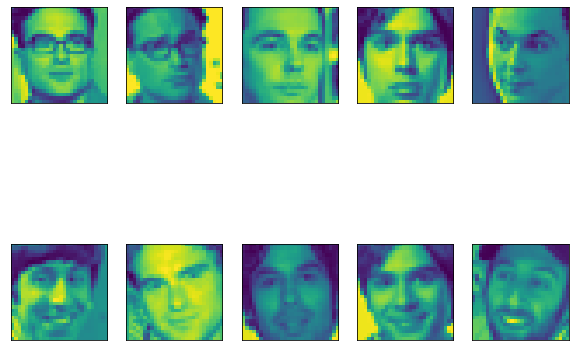

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5,figsize = (10,8))
for i in range(10):
    image = x_train[i].copy()
    ax.flatten()[i].imshow(np.squeeze(image),cmap = 'gray')

plt.setp(ax, xticks=[], yticks=[])
plt.show()

In [9]:
num_classes = 4

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)
y_valid[0]

array([0., 0., 0., 1.], dtype=float32)

## Normalize

In [10]:
x_valid = np.array(x_valid)
x_train = np.array(x_train)
x_test = np.array(x_test)
if x_train.max() == 255:
    x_valid = x_valid/255
    x_train = x_train/255
    x_test = x_test/255

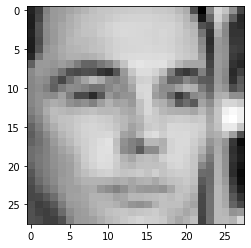

array([0., 0., 1., 0.], dtype=float32)

In [11]:
plt.imshow(x_train[2], cmap = 'gray')
plt.show()
y_train[2]

In [12]:
#Holds the quantity and reshapes it to get the color channels at the last dim. Gray = 1 channel; RGB = 3 channels
x_train = x_train.reshape(-1,img_size,img_size,1)
x_valid = x_valid.reshape(-1,img_size,img_size,1)
x_test = x_test.reshape(-1,img_size,img_size,1)
x_train.shape, x_test.shape, x_valid.shape

((235, 28, 28, 1), (51, 28, 28, 1), (51, 28, 28, 1))

# Data Augmentation

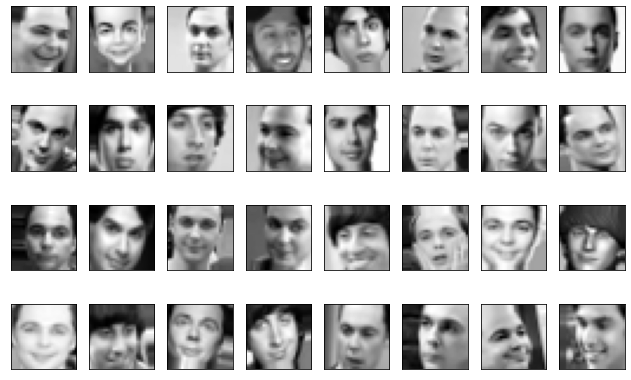

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #samplewise_center=True,  # set each sample mean to 0
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
)  

batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

#Shows the data augmentation results
x_, y_ = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8,figsize = (11,7))
for i in range(batch_size):
    image = x_[i].copy()
    ax.flatten()[i].imshow(np.squeeze(image),cmap = 'gray')

plt.setp(ax, xticks=[], yticks=[])
plt.show()

# Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization
)

def create_model(*args):
    name = str(args)
    model = Sequential()
    model.add(Conv2D(args[0], (3, 3), strides=1, padding="same", activation="relu",input_shape=(img_size, img_size, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(args[1], (3, 3), strides=1, padding="same", activation="relu"))
    model.add(Dropout(args[2]))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(args[3], (3, 3), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    
    model.add(Flatten())
    model.add(Dense(units=args[4], activation="relu"))
    model.add(Dropout(args[5]))
    model.add(Dense(units=num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy",optimizer = 'adam', metrics=["accuracy"])
    return model,name

def show_results(hist,name=''):
    """Plots the results with the history object from model.fit

    Args:
        hist (model.fit): _description_
        name (str, optional): The parameters to show with the plotting. Defaults to ''.
    """
    print(name)
    fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(10,7),sharex=True)
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    ax[0].plot(acc)
    ax[0].plot(val_acc)
    ax[0].legend(['Train','Valid'])
    ax[0].set_title("Accuracy")

    ax[1].plot(loss)
    ax[1].plot(val_loss)
    ax[1].set_title("Loss")
    ax[1].legend(['Train','Valid'])
    plt.show()

In [27]:
# Creates the model and shows its summary
model,name = create_model(75,50,0.2,25,128,.2)
model.summary()

ValueError: ignored

In [ ]:
# Executes the training
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10, restore_best_weights = True)
history = model.fit(img_iter,
          epochs=20,
          verbose=1,
          steps_per_epoch=len(x_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(x_test,y_test),
          callbacks= [callback])

show_results(history,name)

In [ ]:
#Sem generator
#Descartada a possibilidade de realizar sem generator
#model,name = create_model(225,100,0.2,25,512,.2)
#history = model.fit(x_train, y_train, epochs=20, verbose=1, validation_data=(x_valid, y_valid),callbacks = [callback])
#show_results(history,name)

## Saves the Model

In [ ]:
model.save('Last_Model')

!zip -r /content/Last_Model.zip/content/Last_Model
#files.download('Last_Model.zip')

# Validation

In [ ]:
# Loads the model
model = keras.models.load_model('Last_Model')

correct = 0
for xv,yv in zip(x_test,y_test):
    # Predicts each image in the "test" sub-dataset
    pred=model.predict(xv.reshape(1,img_size,img_size,1))
    print(pred)
    # Plots the image
    plt.imshow(xv.reshape(img_size,img_size),cmap='gray')

    # Shows the correct and actual answers with the plots
    print('resposta:',list(class_dict.keys())[np.argmax(pred)],'. Correto:',list(class_dict.keys())[np.argmax(yv)],'\n')
    if list(class_dict.keys())[np.argmax(pred)]==list(class_dict.keys())[np.argmax(yv)]:
        correct+=1

    # Shows
    plt.show()
    print('\n')
#Compilado de % de acerto ao final
print(correct/len(x_test)*100,'% de acerto')